In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Imports
import itertools
import pickle

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# 0) Load
---

In [2]:
folder = '/home/lgriffin/Documents/Jupyter/Kaggle/Data/PUBG/'

training_set = pd.read_csv(folder+'train_V2.csv')
test_set = pd.read_csv(folder+'test_V2.csv')
sample = pd.read_csv(folder+'sample_submission_V2.csv')

# 1) Feature Engineering
***

In [3]:
print('Features: ')
print(training_set.columns.values)

Features: 
['Id' 'groupId' 'matchId' 'assists' 'boosts' 'damageDealt' 'DBNOs'
 'headshotKills' 'heals' 'killPlace' 'killPoints' 'kills' 'killStreaks'
 'longestKill' 'matchDuration' 'matchType' 'maxPlace' 'numGroups'
 'rankPoints' 'revives' 'rideDistance' 'roadKills' 'swimDistance'
 'teamKills' 'vehicleDestroys' 'walkDistance' 'weaponsAcquired'
 'winPoints' 'winPlacePerc']


>## a) Create some new features

In [4]:
#Strip fpp/tpp off of matchType
def strip(row):    
    if 'normal-' in row:
        if '-fpp' in row:
            return row[7:-4]
        else:
            return row[7:]
    elif '-fpp' in row:
        return row[:-4]
    elif 'fpp' in row or 'tpp' in row:
        return row[:-3]
    else:
        return row

def create_features(dataframe):
    #create a flag for fpp
    dataframe['fppFlag'] = dataframe['matchType'].apply(lambda x: 1 if 'fpp' in x else 0)
    
    #create a players in match feature
    dataframe['playersInMatch'] = dataframe.groupby('matchId')['matchId'].transform('count')
    
    #strip matchType
    dataframe['matchTypeStriped'] = dataframe['matchType'].apply(strip)
    
    #create a flag to identify if the player has rank info
    dataframe['hasRankData'] = dataframe['rankPoints'].apply(lambda x: 0 if x == -1 else 1)
    
    #remove the magic values
    dataframe['rankPoints'] =  dataframe['rankPoints'].apply(lambda x: 0 if x == -1 else x)

> ## b) Encode matchType

In [5]:
#Call strip and encode match type
def encode_matchtype(dataframe):
    #Encode matchType
    enc = OneHotEncoder(sparse=False)
    label = LabelEncoder()
    labeled_matchType = label.fit_transform(dataframe['matchTypeStriped'].values)
    dataframe[['crash', 'duo', 'flare', 'solo', 'squad']] = \
        pd.DataFrame(enc.fit_transform(labeled_matchType.reshape(-1,1)), 
        columns=label.classes_, index=dataframe.index)


In [6]:
create_features(training_set)
encode_matchtype(training_set)
train = training_set

# 2) Inspect Data
---

> ## a) Check for nulls

In [7]:
#First step, any NaNs, etc.?
train[train.isnull().any(axis=1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,fppFlag,playersInMatch,matchTypeStriped,hasRankData,crash,duo,flare,solo,squad
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,NaN,1,1,solo,1,0.0,0.0,0.0,1.0,0.0


In [8]:
#Yep, remove it
train.drop(2744604, inplace=True)

>## b) Get a subset

In [9]:
# Get a small subset to make things easier/ make it run faster
train.reindex(np.random.permutation(train.index))
plot_subset = train.head(10000)

> ## c) Check correlations

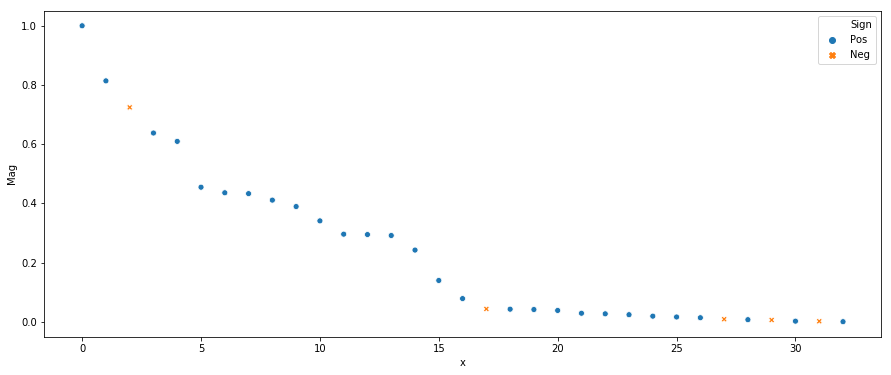

['winPlacePerc' 'walkDistance' 'killPlace' 'boosts' 'weaponsAcquired'
 'damageDealt' 'kills' 'heals' 'longestKill' 'killStreaks' 'rideDistance'
 'headshotKills' 'assists' 'DBNOs' 'revives' 'swimDistance'
 'vehicleDestroys' 'squad' 'roadKills' 'numGroups' 'maxPlace' 'duo'
 'rankPoints' 'solo' 'teamKills' 'hasRankData' 'fppFlag' 'crash'
 'matchDuration' 'winPoints' 'playersInMatch' 'killPoints' 'flare']


In [10]:
#Start by looking at how the features are correlated with the target
correlations = plot_subset.corr()['winPlacePerc']
corr_mag_sign = pd.DataFrame(np.transpose([np.abs(correlations.values), correlations.apply(lambda x: 'Neg' if x<0 else 'Pos').values])
                           , columns=['Mag','Sign'], index=correlations.index.values)
corrs_ranked = corr_mag_sign.sort_values('Mag', ascending=False)
corrs_ranked['x'] = np.arange(corrs_ranked.shape[0])

fig = plt.figure(figsize=(15,6))
ax = sns.scatterplot(x='x',y='Mag',hue='Sign', style='Sign', data=corrs_ranked, )
plt.show()
print(corrs_ranked.index.values)

> ## d) Check the relationships

Two components explain 99.1% of the variance:
    Comp 1 explained variance:  68.76999054602149
    Comp 2 explained variance:  30.479877414822287


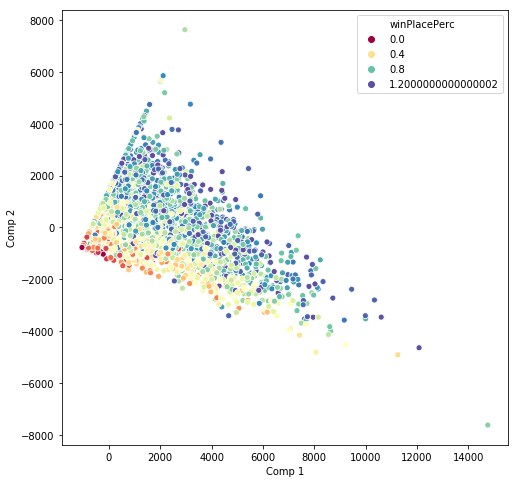

In [11]:
#Lets start by looking at the most strongly correlated (top 16)
features = corrs_ranked.index.values[1:17]
target = 'winPlacePerc'

#What do these relationships actually look like???
#Use decomposition to view the data

decomp = PCA(2)
decomposed = decomp.fit_transform(plot_subset[features])
print('Two components explain 99.1% of the variance:')
print('    Comp 1 explained variance: ',decomp.explained_variance_ratio_[0]*100)
print('    Comp 2 explained variance: ',decomp.explained_variance_ratio_[1]*100)

fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=decomposed[:,0], y=decomposed[:,1], hue=plot_subset[target], palette='Spectral')
ax.set(xlabel='Comp 1', ylabel='Comp 2')
plt.show()

Looks pretty linear! This makes sense sense the .corr() uses the pearson method. Which is a measure of linear correlation.

> ## e) Scale Data

In [12]:
train[features].describe()

,walkDistance,killPlace,boosts,weaponsAcquired,damageDealt,kills,heals,longestKill,killStreaks,rideDistance,headshotKills,assists,DBNOs,revives,swimDistance,vehicleDestroys
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,1.154218e+03,4.759936e+01,1.106908e+00,3.660488e+00,1.307172e+02,9.247835e-01,1.370148e+00,2.299760e+01,5.439553e-01,6.061158e+02,2.268196e-01,2.338150e-01,6.578757e-01,1.646590e-01,4.509323e+00,7.918209e-03
std,1.183497e+03,2.746293e+01,1.715794e+00,2.456543e+00,1.707806e+02,1.558445e+00,2.679982e+00,5.097262e+01,7.109721e-01,1.498344e+03,6.021553e-01,5.885731e-01,1.145743e+00,4.721671e-01,3.050220e+01,9.261158e-02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.551000e+02,2.400000e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.856000e+02,4.700000e+01,0.000000e+00,3.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.976000e+03,7.100000e+01,2.000000e+00,5.000000e+00,1.860000e+02,1.000000e+00,2.000000e+00,2.132000e+01,1.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.578000e+04,1.010000e+02,3.300000e+01,2.360000e+02,6.616000e+03,7.200000e+01,8.000000e+01,1.094000e+03,2.000000e+01,4.071000e+04,6.400000e+01,2.200000e+01,5.300000e+01,3.900000e+01,3.823000e+03,5.000000e+00


These features are huge, should scale them down

In [13]:
#scale them down according to number of deviations away from the mean
def scale_features(dataframe, features):
    dataframe[features] = dataframe[features].apply(lambda x: (x - x.mean())/(x.std()))

In [14]:
scale_these = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills',
            'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks',
            'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints',
            'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
            'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
            'playersInMatch', 'rankPoints']

scale_features(train, scale_these)

# 3) First Model - Linear Model
___

In [15]:
#----- Select Features -----
#Start simple
#Scatter plots show that the top 16 correlated features are quite linear:
#Try a linear model with those features
features = corrs_ranked.index.values[1:17]


#----- Model --------
#Simple linear SGD
model = SGDRegressor(alpha=0.001, average=False,
   epsilon=0.1, eta0=0.1, fit_intercept=True,
   learning_rate='optimal', loss='squared_loss',
   n_iter=None, penalty='l2', power_t=0.25,
   random_state=0, shuffle=True, tol=None,
   verbose=0, warm_start=False, max_iter=1000)


#----- Train and Validate ------
#start with a subset
subset = train[features].head(10000)
subset_targets = train[target].head(10000)

#Use a simple 25% hold out for validation
x_train, x_valid, y_train, y_valid = train_test_split(subset.values, 
                                                      subset_targets.values, test_size=0.25)  

fitted = model.fit(x_train, y_train)
y_valid_predict = fitted.predict(x_valid)
print('R2: ', fitted.score(x_valid, y_valid))
print('MSE: ', mean_squared_error(y_valid, y_valid_predict))
print('MAE: ', mean_absolute_error(y_valid, y_valid_predict))

R2:  0.810954507250582
MSE:  0.017643560793754343
MAE:  0.09812643798358571


Not bad! Let's see how it compares to a Random forest with all features

# 4) Second Model - Random Forest
---

In [16]:
#----- Select Features
features = corrs_ranked.index.values[1:]


#----- Model
#Lets see if we can imporve accuracy with a Random Forest regressor
model = RandomForestRegressor(n_estimators=26, criterion='mse', verbose=1,
                              oob_score=True, random_state=0, bootstrap=True, 
                              max_depth=None, max_features='auto', min_samples_leaf=2, 
                              min_samples_split=5
                             )

#----- Train and Validate
#start with a subset
subset = train[features].head(10000)
subset_targets = train[target].head(10000)

#Use a simple 25% hold out for validation
x_train, x_valid, y_train, y_valid = train_test_split(subset.values, 
                                                      subset_targets.values, test_size=0.25)  

fitted = model.fit(x_train, y_train)
y_valid_predict = fitted.predict(x_valid)
print('R2: ', fitted.score(x_valid, y_valid))
print('MSE: ', mean_squared_error(y_valid, y_valid_predict))
print('MAE: ', mean_absolute_error(y_valid, y_valid_predict))

R2:  0.8931518488538399
MSE:  0.010037145182098306
MAE:  0.06996748994454263


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.0s finished


Quite a bit better!